# **Architectural Likeness Elucidator (ALE) - Primer Modelo**

Primero se descargan los datasets de Kaggle medinte el uso de su API y un token de usario.

In [1]:
#!pip install -q kaggle
#from google.colab import files
#files.upload()
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d dumitrux/architectural-styles-dataset
#!unzip architectural-styles-dataset.zip -d /content/

Importar las librerias necesarias

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
import glob
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Obtener la dirección de las imágenes

In [3]:
dataDIR = "../data/architectural-styles-dataset/"
datasetDIR = pathlib.Path(dataDIR)

imageCount = len(list(datasetDIR.glob("*/*.jpg")))
print("Total Images in Dataset:")
print(imageCount)

Total Images in Dataset:
10113


Definir Estilos Arquitectónicos

In [4]:
styles = ['Achaemenid architecture','American craftsman style','American Foursquare architecture','Ancient Egyptian architecture','Art Deco architecture',
    'Art Nouveau architecture','Baroque architecture','Bauhaus architecture','Beaux-Arts architecture','Byzantine architecture',
    'Chicago school architecture','Colonial architecture','Deconstructivism','Edwardian architecture','Georgian architecture',
    'Gothic architecture','Greek Revival architecture','International style','Novelty architecture','Palladian architecture',
    'Postmodern architecture','Queen Anne architecture','Romanesque architecture','Russian Revival architecture','Tudor Revival architecture']

numStyles = len(styles)

Resize images in order to normalize the dataset

In [5]:
# Separate image dataset into features and labels (target = style)
X = []
y = []

# Set size for images to be resized to
size = (256, 256)

# Put images in X and their labels in y
for style in styles[:]:
    imgFile = glob.glob(f'data/architectural-styles-dataset/**/{style}/*.jpg', recursive = True)

    # Resize and grayscale each image
    for i, f in enumerate(imgFile):
        img = cv2.imread(f)
        img = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = img.astype('float32')
        img /= 255
        X.append(img)
        y.append(style)

Create train and validation datasets

In [6]:
trainDs = tf.keras.utils.image_dataset_from_directory(datasetDIR, validation_split=0.2,subset="training",seed=123, image_size=(256,256), batch_size=32)
valDs = tf.keras.utils.image_dataset_from_directory(datasetDIR, validation_split=0.2,subset="validation",seed=123,image_size=(256,256),batch_size=32 )

className = trainDs.class_names
print(className)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.
Found 10113 files belonging to 25 classes.
Using 2022 files for validation.
['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


Plot some images from the dataset with their respective styles

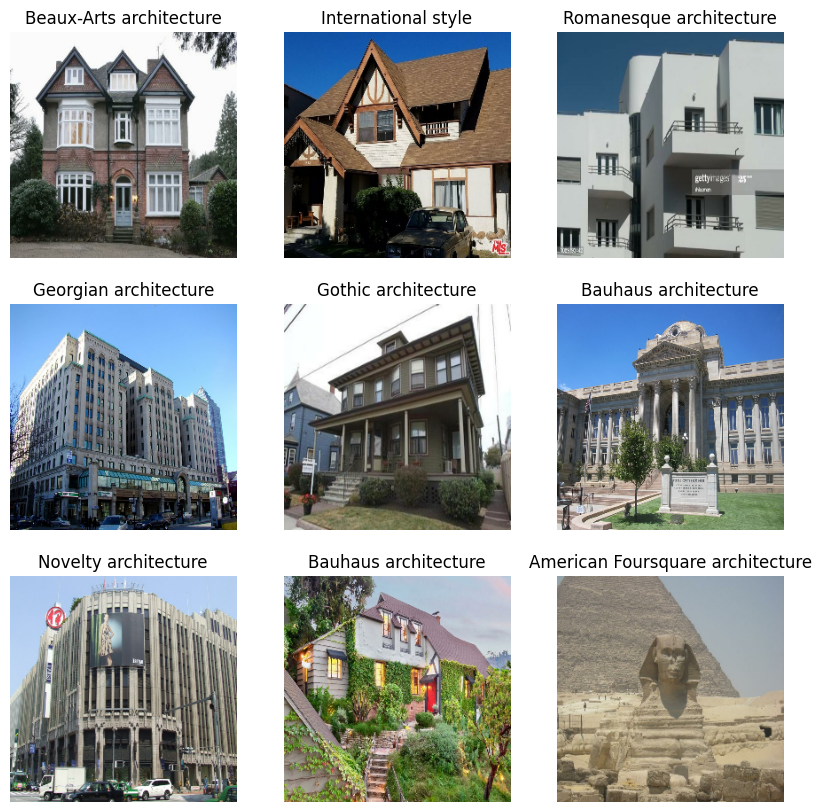

In [7]:
plt.figure(figsize=(10,10))
for images, styles in trainDs.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(className[styles[i]])
    plt.axis("off")

Normalize dataset layers

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

trainDs = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valDs = valDs.cache().prefetch(buffer_size=AUTOTUNE)

normalizationLayer = layers.Rescaling(1./255)

normalizedDs = trainDs.map(lambda x, y: (normalizationLayer(x),y))
imageBatch, labelsBatch = next(iter(normalizedDs))
firstImage = imageBatch[0]

# Notice how the pixel value are now in [0,1]
print(np.min(firstImage), np.max(firstImage))

0.0 1.0


Create the model

In [9]:
numClasses = len(className)

model  = Sequential([layers.Rescaling(1./255, input_shape=(256, 256, 3)), layers.Conv2D(16,3,padding="same",activation="relu"), layers.MaxPooling2D(), layers.Conv2D(32,3,padding="same",activation="relu"), layers.MaxPooling2D(),layers.Conv2D(64,3,padding="same",activation="relu"),layers.MaxPooling2D(),layers.Dropout(0.2),layers.Flatten(),layers.Dense(128,activation="relu"),layers.Dense(numClasses)])

model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

c:\Users\ivanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sumarize the previously created model

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,415,545 (32.10 MB)

 Trainable params: 8,415,545 (32.10 MB)

 Non-trainable params: 0 (0.00 B)

Train the model with the proper datasets

In [11]:
epochs = 15
history = model.fit(trainDs,validation_data=valDs,epochs=epochs)

Epoch 1/15
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.0637 - loss: 3.4456

: 

Test the trained model with new pictures in order to find errors

In [ ]:
#ArtDeco
img = tf.keras.utils.load_img("../data/TestImages/ArtDecoEx.png", target_size=(256, 256))

imgArray  = tf.keras.utils.img_to_array(img)
imgArray = tf.expand_dims(imgArray, 0) #Create batch

predictions = model.predict(imgArray)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(className[np.argmax(score)], 100 *  np.max(score)))

In [ ]:
#Post-Modern
img2 = tf.keras.utils.load_img("../data/TestImages/PostModernEx.png", target_size=(256, 256))

imgArray2  = tf.keras.utils.img_to_array(img2)
imgArray2 = tf.expand_dims(imgArray2, 0) #Create batch

predictions2 = model.predict(imgArray2)
score2 = tf.nn.softmax(predictions2[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(className[np.argmax(score2)], 100 *  np.max(score2)))